In [ ]:
# Run below commands
!apt-get install openjdk-8-jdk-headless -qq > /dev/null #Install java
!wget -q https://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz ## Install Apache Spark
!tar xf spark-3.4.1-bin-hadoop3.tgz
!pip install -q findspark
!pip install pyspark==3.4.1
!pip install numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285388 sha256=7677d71bd5483be7d204798312014c9662d386ec2064223f6b9a83e29a5767b3
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [ ]:
import os
import findspark
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from datetime import datetime, date, timedelta
from dateutil import relativedelta
from pyspark.sql import SQLContext, Row
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import DataFrame
from pyspark.sql.functions import *
from pyspark.sql.functions import to_timestamp, to_date
from pyspark.sql import functions as F
from pyspark.sql.functions import collect_list, collect_set, concat, first, array_distinct, col, size, expr
from pyspark.sql import DataFrame
import random
import numpy as np
from pyspark.sql.functions import col, when, count, sum
import pandas as pd
from pyspark.sql.functions import explode

# find spark easily
findspark.init()

# Define Java and Spark home path in Google Colab
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"

# ***Text Analytics***

#### *** first task is to open your Venmo app, find 10 words that are not already in the dictionary and add them to it. Make sure you don’t add to the dictionary a duplicate word by hitting Control+F before adding your word.***

- **New Added 10 Words: "Celsius", "Renew", "Din Din", "Taichi", "Saigon", "Buh", "Peanuts", "Sweatshirt", "LPEA", "Washer".**

#### ***Use the text dictionary and the emoji dictionary to classify Venmo’s transactions in your sample dataset. What is the percent of emoji only transactions? Which are the top 5 most popular emoji? Which are the top three most popular emoji categories?***


In [ ]:
#Upload dataset files
from google.colab import files
files.upload()

Saving word.csv to word.csv


{'word.csv': b"People,Food,Event,Activity,Travel,Transportation,Utility,Cash,Illegal/Sarcasm,@dropdown\r\nfriend,food,birthday,ball,beach,lyft,bill,atm ,addiction,\r\nfriendship,bbq,christmas,boat,place,uber,cable,bank ,drug,\r\nbaby,bean,happy,bar,la,cab,fee,cash ,wangs,\r\nboy,latte,bday,book,world,bus,electric,money,weed,\r\ngirl,breakfast,wedding,club,hotel,car,electricity,buck,anal,\r\nhelp,brunch,xmas,card,trip,gas,internet,wallet,bj,\r\nlike,burger,holiday,dance,vega,taxi,rent,monies,blowjob,\r\nlove,burrito,hbd,football,tahoe,ride,wifi,tip,boob,\r\nmom,cake,halloween,fun,nyc,rental ,utility,dollar,booty,\r\nsave,cheese,thanksgiving,game,dc,train,tax,payback,blow,\r\nsweet,chicken,bachelor,gift,sf,\xc3\xbcber,refund,lettuce,cocaine,\r\ntank,coffee,gift,golf,island,ubers,house,watch,cock,\r\nthank,chip,donation,hair,cabo,gasolina,billz,hat,dirty,\r\nthanks,chinese,charity,pt,chicago,airport,deposit,supreme,dd,\r\nthx,chipotle,aid,movie,airbnb,fuel,pg,bitcoin,crack,\r\nya,cream,ny

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local")\
        .appName("Venmo Analysis")\
        .getOrCreate()

In [ ]:
#upload file from google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#Load the emoji dictionary
emoji_dict = pd.read_csv("/content/emoji.csv")

#load the word dictionary
word_dict = pd.read_csv("/content/word.csv")

#load the Venmo transactions dataset
venmo_data = spark.read.parquet("/content/drive/MyDrive/VenmoSample.snappy.parquet")

In [ ]:
emoji_dict.head(10)

,Event,Travel,Food,Activity,Transportation,People,Utility
0,🇦🇺,🏔,🍇,👾,🚄,😀,⚡
1,🇫🇷,⛰,🍈,🕴,🚅,😃,💡
2,🎂,🌋,🍉,🎪,🚆,😄,🔌
3,🛍,🗻,🍊,🎭,🚇,😁,📺
4,🇨🇦,🏕,🍋,🎨,🚈,😆,🔌
5,🇧🇷,🏖,🍌,🎰,🚉,😅,⚡
6,🐉,🏜,🍍,🚣,🚊,🤣,💡
7,🎅,🏝,🍎,🛀,🚝,😂,💸
8,🇲🇽,🏞,🍏,🎗,🚞,🙂,💦
9,🇨🇳,🏟,🍐,🎟,🚋,🙃-,💧


In [ ]:
word_dict.head(10)

,People,Food,Event,Activity,Travel,Transportation,Utility,Cash,Illegal/Sarcasm,@dropdown
0,friend,food,birthday,ball,beach,lyft,bill,atm,addiction,NaN
1,friendship,bbq,christmas,boat,place,uber,cable,bank,drug,NaN
2,baby,bean,happy,bar,la,cab,fee,cash,wangs,NaN
3,boy,latte,bday,book,world,bus,electric,money,weed,NaN
4,girl,breakfast,wedding,club,hotel,car,electricity,buck,anal,NaN
5,help,brunch,xmas,card,trip,gas,internet,wallet,bj,NaN
6,like,burger,holiday,dance,vega,taxi,rent,monies,blowjob,NaN
7,love,burrito,hbd,football,tahoe,ride,wifi,tip,boob,NaN
8,mom,cake,halloween,fun,nyc,rental,utility,dollar,booty,NaN
9,save,cheese,thanksgiving,game,dc,train,tax,payback,blow,NaN


In [ ]:
venmo_data.show(10)

+-------+-------+----------------+-------------------+---------------+-----------+--------------------+
|  user1|  user2|transaction_type|           datetime|    description|is_business|            story_id|
+-------+-------+----------------+-------------------+---------------+-----------+--------------------+
|1218774|1528945|         payment|2015-11-27 10:48:19|           Uber|      false|5657c473cd03c9af2...|
|5109483|4782303|         payment|2015-06-17 11:37:04|         Costco|      false|5580f9702b64f70ab...|
|4322148|3392963|         payment|2015-06-19 07:05:31|   Sweaty balls|      false|55835ccb1a624b14a...|
| 469894|1333620|          charge|2016-06-03 23:34:13|             🎥|      false|5751b185cd03c9af2...|
|2960727|3442373|         payment|2016-05-29 23:23:42|              ⚡|      false|574b178ecd03c9af2...|
|3977544|2709470|         payment|2016-09-29 22:12:07|     Chipotlaid|      false|57ed2f4723e064eac...|
|3766386|4209061|         payment|2016-05-20 10:31:15|kitchen cou

In [ ]:
emoji_only_transactions = venmo_data.filter(col("description").rlike("^[\\p{So}\\p{Sc}]+$"))
emoji_only_transactions.show(10)

+--------+-------+----------------+-------------------+-----------+-----------+--------------------+
|   user1|  user2|transaction_type|           datetime|description|is_business|            story_id|
+--------+-------+----------------+-------------------+-----------+-----------+--------------------+
|  469894|1333620|          charge|2016-06-03 23:34:13|         🎥|      false|5751b185cd03c9af2...|
| 2960727|3442373|         payment|2016-05-29 23:23:42|          ⚡|      false|574b178ecd03c9af2...|
| 5317324|3942984|         payment|2016-01-04 09:11:25|         👠|      false|5689c6bdcd03c9af2...|
| 4238868|4879587|         payment|2015-10-04 08:28:01|         🍺|      false|561080a1cd03c9af2...|
|11719500|8702716|         payment|2016-07-07 21:40:39|          ⛽|      false|577e69e723e064eac...|
| 9414481|2869012|         payment|2016-04-09 09:19:46|         🔴|      false|570866c2cd03c9af2...|
|  444145| 323088|         payment|2013-11-22 05:03:43|       ✌❤🏈|      false|528e752fd56b6bac5

In [ ]:
# Calculate the total number of transactions and emoji-only transactions
total_transactions = venmo_data.count()
emoji_only_count = emoji_only_transactions.count()

# Calculate the percentage of emoji only transactions
emoji_only_percentage = (emoji_only_count / total_transactions) * 100

print(f'{emoji_only_percentage}% of transactions are emoji-only transactions.')

19.66794678634757% of transactions are emoji-only transactions.


In [ ]:
import regex

# UDF to extract emojis from text
def extract_emojis(text):
    # Regular expression to match all emojis
    emoji_pattern = regex.compile("[\\p{So}\\p{Sc}]", flags=regex.UNICODE)
    # Find all emojis in the text
    return emoji_pattern.findall(text)

# Register UDF in Spark
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType

extract_emojis_udf = udf(extract_emojis, ArrayType(StringType()))

In [ ]:
venmo_data_with_emojis = venmo_data.withColumn("emojis", extract_emojis_udf(col("description")))

# Create a new DataFrame where each emoji is in its own row
emoji_exploded = venmo_data_with_emojis.select(explode(col("emojis")).alias("emoji"))

# Count each emoji's occurrence and order by count
top_emojis = emoji_exploded.groupBy("emoji").agg(count("*").alias("count")).orderBy(col("count").desc())

In [ ]:
# Show the top 5 emojis
top_emojis.show(5)

+-----+------+
|emoji| count|
+-----+------+
|   🍕|215039|
|   🍻|145233|
|   💸|124727|
|   🍷|111157|
|   🎉| 94327|
+-----+------+
only showing top 5 rows



In [ ]:
# convert the emoji dict df to long df format
emoji_dict_long = emoji_dict.melt(var_name='Category', value_name='emoji').dropna()

# convert emoji_dict_long to a spark dataframe
emoji_dict_spark = spark.createDataFrame(emoji_dict_long)

# left join two tables to get category info for each emoji in transactions
emoji_joined = emoji_exploded.join(emoji_dict_spark, "emoji", "left")
emoji_joined = emoji_joined.fillna({'category': 'other category'})

top_emojis_category = emoji_joined.groupBy("Category").agg(count("*").alias("count")).orderBy(col("count").desc())
top_emojis_category.show(3)

+--------------+-------+
|      Category|  count|
+--------------+-------+
|          Food|1744390|
|other category|1654578|
|        People|1011889|
+--------------+-------+
only showing top 3 rows



#### **For each user, create variables to classify their spending behavior profile into categories. For example, if a user has made 10 transactions, where 5 of them are food and the other 5 are activity, then the user’s spending profile will be 50% food and 50% activity.**

In [ ]:
# convert the emoji dict df to long df format
word_dict_long = word_dict.melt(var_name='Category', value_name='text').dropna()

# convert the emoji dict df to long df format
emoji_dict_long = emoji_dict.melt(var_name='Category', value_name='text').dropna()

# union word_dict_long and emoji_dict_long
combined_dict = pd.concat([word_dict_long, emoji_dict_long], ignore_index=True)

# convert combined_dict to spark df
combined_dict = spark.createDataFrame(combined_dict)

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, explode, split, col
from pyspark.sql.types import ArrayType, StringType
import re

# Regex pattern to identify emojis
emoji_pattern = r'[\U00010000-\U0010ffff]'

# UDF to separate words and unique emojis
def separate_emojis(text):
    # Find all unique emojis
    emojis = list(set(re.findall(emoji_pattern, text)))
    # Remove emojis from text to split words
    words = re.sub(emoji_pattern, '', text).split()
    # Combine words and unique emojis
    return words + emojis

# Register the UDF
separate_emojis_udf = udf(separate_emojis, ArrayType(StringType()))

# Apply the UDF and explode
df_exploded = venmo_data.withColumn("description_exploded", separate_emojis_udf(col("description")))
df_exploded = df_exploded.withColumn("description_exploded", explode("description_exploded"))

In [ ]:
# left join df_exploded and combined_dict, and fillna with "others"
venmo_data = df_exploded.join(combined_dict, df_exploded.description_exploded == combined_dict.text, "left")
venmo_data = venmo_data.select("user1", "user2", "datetime", "story_id", "description_exploded", "Category")
venmo_data = venmo_data.na.fill({'Category': "Other"})

In [ ]:
venmo_data.show()

+--------+-------+-------------------+--------------------+--------------------+--------------+
|   user1|  user2|           datetime|            story_id|description_exploded|      Category|
+--------+-------+-------------------+--------------------+--------------------+--------------+
| 1134661|1556430|2015-10-09 01:53:52|5616bbc0cd03c9af2...|                babe|        People|
| 3766386|4209061|2016-05-20 10:31:15|573e8503cd03c9af2...|             counter|         Other|
|  730075| 804466|2016-05-26 04:46:45|57461d46cd03c9af2...|                Food|         Other|
| 5109483|4782303|2015-06-17 11:37:04|5580f9702b64f70ab...|              Costco|         Other|
| 3625798|5692302|2016-10-16 14:43:41|58032fad23e064eac...|                 man|        People|
| 6843582|7308338|2016-08-31 10:32:46|57c64fdf23e064eac...|               sucks|         Other|
| 3625798|5692302|2016-10-16 14:43:41|58032fad23e064eac...|                it's|         Other|
| 1134661|1556430|2015-10-09 01:53:52|56

In [ ]:
# calculate the spending profile for each user
spending_category = venmo_data.groupBy("user1", "Category").agg(count("*").alias("count"))
spending_total = spending_category.groupBy("user1").agg(sum("count").alias("total"))
spending_total = spending_total.withColumnRenamed("user1", "user_1")
spending_profile = spending_category.join(spending_total, spending_category.user1 == spending_total.user_1, "inner")


In [ ]:
spending_profile = spending_profile.withColumn("spending_profile", col("count")*100 / col("total"))
spending_profile = spending_profile.withColumn("spending_profile_percent", concat(format_number("spending_profile", 2), lit("%")))
spending_profile = spending_profile.select("user1", "Category", "spending_profile_percent")
spending_profile.show()

+-----+---------------+------------------------+
|user1|       Category|spending_profile_percent|
+-----+---------------+------------------------+
|    3|           Food|                   1.28%|
|    3|         People|                   1.28%|
|    3|          Other|                  97.44%|
|    4|Illegal/Sarcasm|                  11.11%|
|    4|          Other|                  44.44%|
|    4|           Food|                  11.11%|
|    4|         Travel|                  11.11%|
|    4|       Activity|                  22.22%|
|   10|           Food|                  10.34%|
|   10|          Other|                  86.21%|
|   10| Transportation|                   3.45%|
|   12|        Utility|                   1.61%|
|   12|          Other|                  95.16%|
|   12|           Food|                   1.61%|
|   12|       Activity|                   1.61%|
|   13|       Activity|                   1.33%|
|   13|          Event|                   0.33%|
|   13|           Fo

#### ** you got a static spending profile. However, life and social networks are evolving over time. Therefore, let’s explore how a user’s spending profile is evolving over her lifetime in Venmo. First of all, you need to analyze a user’s transactions in monthly intervals, starting from 0 (indicating their first transaction only) up to 12.**

In [ ]:
from pyspark.sql.functions import col, min, months_between, to_date
from pyspark.sql.window import Window

# Ensure datetime column is of DateType
spending_trend = venmo_data.withColumn("datetime", to_date(col("datetime")))

# Calculate the month interval from each user's first transaction
window_spec = Window.partitionBy("user1").orderBy("datetime")
spending_trend = spending_trend.withColumn("first_transaction", min("datetime").over(window_spec))
spending_trend = spending_trend.withColumn("month_interval", (months_between(col("datetime"), col("first_transaction"))).cast("int"))

spending_trend.show()


+-----+------+----------+--------------------+--------------------+--------+-----------------+--------------+
|user1| user2|  datetime|            story_id|description_exploded|Category|first_transaction|month_interval|
+-----+------+----------+--------------------+--------------------+--------+-----------------+--------------+
|   28|769787|2014-05-22|537d7c4fd546b8434...|             Izakaya|    Food|       2014-05-22|             0|
|   34|  5114|2014-07-21|53cd40587d0b0354e...|                Giwa|   Other|       2014-07-21|             0|
|   34|  5114|2014-07-21|53cd40587d0b0354e...|               sauce|    Food|       2014-07-21|             0|
|   34|934623|2014-09-15|54163a4a7d0b0354e...|                 2nd|   Other|       2014-07-21|             1|
|   34|934623|2014-09-15|54163a4a7d0b0354e...|             already|   Other|       2014-07-21|             1|
|   34|934623|2014-09-15|54163a4a7d0b0354e...|                (350|   Other|       2014-07-21|             1|
|   34|934

In [ ]:
from pyspark.sql.functions import count, avg, stddev

# Aggregate spending profile by user and month_interval
user_spending_profile = spending_trend.groupBy("user1", "month_interval", "Category").agg(count("*").alias("count"))

# Pivot to get spending profile per user per month
user_spending_profile_pivot = user_spending_profile.groupBy("user1", "month_interval").pivot("Category").sum("count").fillna(0)

# Compute average and standard deviation across all users
average_profile = user_spending_profile_pivot.groupBy("month_interval").agg(
    *[avg(col(c)).alias(f"avg_{c}") for c in user_spending_profile_pivot.columns if c not in ["user1", "month_interval"]],
    *[stddev(col(c)).alias(f"stddev_{c}") for c in user_spending_profile_pivot.columns if c not in ["user1", "month_interval"]]
)

average_profile.show()


+--------------+-------------------+--------------------+--------------------+-------------------+--------------------+------------------+-------------------+--------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+----------------------+------------------+-------------------+---------------------+-------------------+-------------------+
|month_interval|       avg_Activity|            avg_Cash|           avg_Event|           avg_Food| avg_Illegal/Sarcasm|         avg_Other|         avg_People|  avg_Transportation|          avg_Travel|        avg_Utility|    stddev_Activity|        stddev_Cash|       stddev_Event|        stddev_Food|stddev_Illegal/Sarcasm|      stddev_Other|      stddev_People|stddev_Transportation|      stddev_Travel|     stddev_Utility|
+--------------+-------------------+--------------------+--------------------+-------------------+--------------------+------------------+------------

In [ ]:
# Filter for the first 12 months
average_profile = average_profile.filter(col("month_interval") <= 12)

<ipython-input-27-67f092e32f97>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(categories))


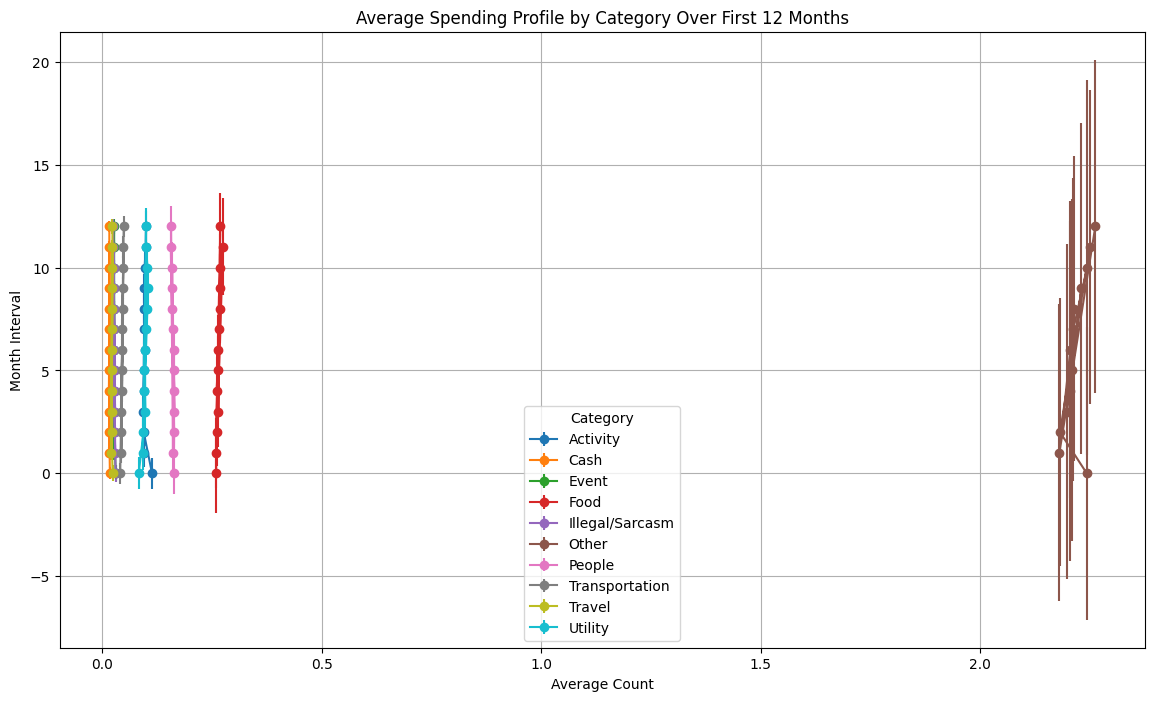

In [ ]:
import matplotlib.pyplot as plt

# Convert to Pandas DataFrame for plotting
average_profile_pd = average_profile.toPandas()

# Plot the average and standard deviation of each category for the first 12 months
plt.figure(figsize=(14, 8))

# List of categories, excluding 'user1' and 'month_interval'
categories = [c[4:] for c in average_profile.columns if c.startswith("avg_")]

# Generate plots for each category with different colors
colors = plt.cm.get_cmap('tab10', len(categories))
for idx, category in enumerate(categories):
    plt.errorbar(
        average_profile_pd[f"avg_{category}"],
        average_profile_pd["month_interval"],
        yerr=2 * average_profile_pd[f"stddev_{category}"],
        fmt='-o',
        label=category,
        color=colors(idx)
    )

plt.title('Average Spending Profile by Category Over First 12 Months')
plt.xlabel('Average Count')
plt.ylabel('Month Interval')
plt.legend(title='Category')
plt.grid(True)
plt.show()


#### **What do you observe? Does the spending profile of the average customer stabilize after some point in time?**

Yes, The spending profile of the average customer stabilize after some point in time. Please note that "other" category means that the context we extract is not in either emoji dictionary or word dictionary. I categorized anything else as "other".

# ***Part 2: Social Network Analytics***

#### **Write a script to find a user’s friends and friends of friends (Friend definition: A user’s friend is someone who has transacted with the user, either sending money to the user or receiving money from the user). Describe your algorithm and calculate its computational complexity. Can you do it better?**

User's Friends:

In [ ]:
# Group by user1 and collect all user2 into a list
friends_list_df = venmo_data.groupBy("user1").agg(collect_set("user2").alias("friends"))

# Show the results: User' friend
friends_list_df.show(truncate=False)

+-----+----------------------------------------------------------------------------------------------------------------------------------------+
|user1|friends                                                                                                                                 |
+-----+----------------------------------------------------------------------------------------------------------------------------------------+
|3    |[52, 1079020, 7854140, 2382556, 1204190]                                                                                                |
|4    |[122744, 9271982, 968271, 221578, 187560, 125527]                                                                                       |
|10   |[255, 36523, 71056, 3844713, 43]                                                                                                        |
|11   |[160300, 6419, 52182, 148622, 118445, 133784, 60183, 146271, 51792, 50225, 183628, 39917, 27351, 29833, 273709, 42, 41798, 

Friends' friends:

In [ ]:
# Group by user1 and collect all user2 into a list
friend_friend = venmo_data.groupBy("user2").agg(collect_set("user1").alias("friend_friend"))

# Show the results
friend_friend.show(truncate=False)

+-----+----------------------------------------------------------------------------+
|user2|friend_friend                                                               |
+-----+----------------------------------------------------------------------------+
|3    |[263437, 43, 567957]                                                        |
|4    |[125755, 125527]                                                            |
|6    |[4330489, 688883, 676003]                                                   |
|8    |[900433, 659067]                                                            |
|9    |[185494, 367955, 243, 755956]                                               |
|10   |[13, 133032, 3844713, 43]                                                   |
|11   |[149919, 160300, 119906, 13, 862680, 275, 42, 179458, 146274, 171286, 54724]|
|12   |[221813, 746556, 1742822, 112, 295034, 26675]                               |
|13   |[126820, 58471, 1941801]                                  

Algorithm:
- I groupby all user1 and concate all unique users2(their friends) into a list by using agg(collect_set()) along with groupby. I used the same algorithm for finding friends of friend.

Computational complexity:
- This algorithm is not computational complex especially when we are dealing this problem using pyspark, a great tool for working with big data.

Potential improvement:
- We can increase the data processing efficiency by caching the dataset into memory.

#### **Now, that you have the list of each user’s friends and friends of friends, you are in position to calculate many social network variables. Use the dynamic analysis from before, and calculate the following social network metrics across a user’s lifetime in Venmo (from 0 up to 12 months).**


#### **1. Number of friends and number of friends of friends \[very easy, 4 pts\]**.

In [ ]:
# friend count
friends_list_df = friends_list_df.withColumn("friends_count", size(friends_list_df["friends"]))
friends_list_df.show()

+-----+--------------------+-------------+
|user1|             friends|friends_count|
+-----+--------------------+-------------+
|    3|[52, 1079020, 785...|            5|
|    4|[122744, 9271982,...|            6|
|   10|[255, 36523, 7105...|            5|
|   11|[160300, 6419, 52...|           19|
|   12|[135778, 156, 112...|            5|
|   13|[212813, 760161, ...|           16|
|   16|[1079065, 615398,...|            7|
|   19|[54533, 54851, 54...|            4|
|   28|            [769787]|            1|
|   34|[934623, 5114, 90...|            4|
|   42|[32, 1176237, 240...|            5|
|   43|[49778, 3565, 96,...|           18|
|   47|       [858, 351854]|            2|
|   52|               [225]|            1|
|   56|[932573, 978409, ...|            4|
|  112|   [12, 221813, 341]|            3|
|  126|       [180436, 725]|            2|
|  129|            [243198]|            1|
|  156|           [1936141]|            1|
|  159|             [85310]|            1|
+-----+----

In [ ]:
# friend_friend count
friend_friend = friend_friend.withColumn("friends_count", size(friend_friend["friend_friend"]))
friend_friend.show()

+-----+--------------------+-------------+
|user2|       friend_friend|friends_count|
+-----+--------------------+-------------+
|    3|[263437, 43, 567957]|            3|
|    4|    [125755, 125527]|            2|
|    6|[4330489, 688883,...|            3|
|    8|    [900433, 659067]|            2|
|    9|[185494, 367955, ...|            4|
|   10|[13, 133032, 3844...|            4|
|   11|[149919, 160300, ...|           11|
|   12|[221813, 746556, ...|            6|
|   13|[126820, 58471, 1...|            3|
|   16|[433753, 1204210,...|            7|
|   19|  [54866, 43, 52568]|            3|
|   24|   [1209436, 704870]|            2|
|   28|            [582796]|            1|
|   29|[332, 298724, 231...|            3|
|   31|               [192]|            1|
|   32|                [42]|            1|
|   34|      [2048982, 907]|            2|
|   42|[225248, 1847419,...|            4|
|   43|[47104, 10, 27643...|            4|
|   47|           [6918132]|            1|
+-----+----

**2. Clustering coefficient of a user's network . (Hint: the easiest way to calculate this is to program it yourselves. Alternatively, you can use “NetworKit” or “networkX” python package. The latter approach will slow down your script significantly).**

In [ ]:
! pip install networkx

In [ ]:
import networkx as nx

friends_list_df  = friends_list_df.select("user1", "friends")
friends_list_df = friends_list_df.toPandas()

# Create an empty graph
G = nx.Graph()

# Add edges to the graph
for index, row in friends_list_df.iterrows():
    user = row['user1']
    friends = row['friends']
    for friend in friends:
        G.add_edge(user, friend)

# Calculate the clustering coefficient for each node
clustering_coefficients = nx.clustering(G)

# Calculate the average clustering coefficient for the graph
average_clustering = nx.average_clustering(G)

print("Clustering Coefficients:", clustering_coefficients)
print("Average Clustering Coefficient:", average_clustering)


**3. Calculate the page rank of each user. (Hint: First of all, you need to use GraphFrames to do this. Moreover, notice that page rank is a global social network metric. If you go ahead and calculate the page rank for each user at each of her lifetime points, you will soon realize it will be a dead end. Can you think of a smart way to do this?)**

In [ ]:
!pip install graphframes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 4.7 MB/s eta 0:00:00


In [ ]:
# convert friends_list_df back to spark df
friends_list_df = spark.createDataFrame(friends_list_df)

edges = friends_list_df.withColumn("friend", explode("friends")).selectExpr("user1 as src", "friend as dst")
vertices = friends_list_df.selectExpr("user1 as id").distinct()


from graphframes import GraphFrame

g = GraphFrame(vertices, edges)

# Run PageRank algorithm
pageRanks = g.pageRank(resetProbability=0.15, tol=0.01, maxIter=10)

# Show the results
pageRanks.vertices.select("id", "pagerank").show()

# ***Part 3 Predictive Analytics with MLlib***

In [ ]:
#Install and import pyspark and java
#!apt-get install openjdk-8-jdk-headless -qq > /dev/null #Install java
#!wget -q https://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz ## Install Apache Spark
#!tar xf spark-3.4.1-bin-hadoop3.tgz
#!pip install -q findspark
#!pip install pyspark==3.4.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285388 sha256=f7242083ec6867c3ff6d7cd054aace9108866edfe8146ebfa9059e460a23e367
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [ ]:
#import os
#from pyspark.sql import SparkSession
#from pyspark.sql.functions import collect_list, collect_set, concat, first, array_distinct, col, size, expr
#import pyspark
# Define Java and Spark home path in Google Colab
#os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
#os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"

In [ ]:
#import findspark
#findspark.init() #adds pyspark to the system path

In [ ]:
# Initialize a SparkSession
#spark = SparkSession.builder \
#    .appName("venmo-analysis") \
#    .getOrCreate()

#spark

In [ ]:
#upload file from google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
df = spark.read.parquet("/content/drive/MyDrive/VenmoSample.snappy.parquet")
#df.show(5)

# First, create your dependent variable Y, i.e. the total number of transactions at lifetime point 12. In other words, for every user, you need to count how many transactions s/he had committed during her/his twelve months in Venmo.

In [ ]:
from pyspark.sql.functions import year, month, col
#calculate the months of user
df = df.withColumn("year", year(col("datetime")))
df = df.withColumn("month", month(col("datetime")))
df.show(5)

+-------+-------+----------------+-------------------+------------+-----------+--------------------+----+-----+
|  user1|  user2|transaction_type|           datetime| description|is_business|            story_id|year|month|
+-------+-------+----------------+-------------------+------------+-----------+--------------------+----+-----+
|1218774|1528945|         payment|2015-11-27 10:48:19|        Uber|      false|5657c473cd03c9af2...|2015|   11|
|5109483|4782303|         payment|2015-06-17 11:37:04|      Costco|      false|5580f9702b64f70ab...|2015|    6|
|4322148|3392963|         payment|2015-06-19 07:05:31|Sweaty balls|      false|55835ccb1a624b14a...|2015|    6|
| 469894|1333620|          charge|2016-06-03 23:34:13|          🎥|      false|5751b185cd03c9af2...|2016|    6|
|2960727|3442373|         payment|2016-05-29 23:23:42|           ⚡|      false|574b178ecd03c9af2...|2016|    5|
+-------+-------+----------------+-------------------+------------+-----------+--------------------+----+

In [ ]:
from pyspark.sql.functions import min
#calculate the start month of users
user_start_month = df.groupBy("user1").agg(min("year").alias("start_year"), min("month").alias("start_month"))
user_start_month.show(5)

+-------+----------+-----------+
|  user1|start_year|start_month|
+-------+----------+-----------+
|3891364|      2016|          1|
|4136881|      2015|          6|
|1841732|      2014|          2|
|2281658|      2014|          8|
| 204908|      2013|          2|
+-------+----------+-----------+
only showing top 5 rows



In [ ]:
from pyspark.sql.functions import expr
df = df.join(user_start_month, on="user1")
#insert the start month back and filter the transactions they did within the first 12 month
df = df.withColumn(
    "months_since_start",
    (col("year") - col("start_year")) * 12 + (col("month") - col("start_month"))
)

df_filtered = df.filter(col("months_since_start") <= 12)
df_filtered.show(5)

+-----+------+----------------+-------------------+--------------------+-----------+--------------------+----+-----+----------+-----------+------------------+
|user1| user2|transaction_type|           datetime|         description|is_business|            story_id|year|month|start_year|start_month|months_since_start|
+-----+------+----------------+-------------------+--------------------+-----------+--------------------+----+-----+----------+-----------+------------------+
|   28|769787|         payment|2014-05-22 11:25:51|             Izakaya|      false|537d7c4fd546b8434...|2014|    5|      2014|          5|                 0|
|   34|934623|         payment|2014-09-15 08:00:57|2nd place (350 - ...|      false|54163a4a7d0b0354e...|2014|    9|      2014|          2|                 7|
|   34|  5114|          charge|2014-07-21 23:31:20|          Giwa sauce|      false|53cd40587d0b0354e...|2014|    7|      2014|          2|                 5|
|   34| 35940|         payment|2014-10-24 02:1

In [ ]:
from pyspark.sql.functions import count

user_transactions = df_filtered.groupBy("user1").agg(count("story_id").alias("total_transactions_in_12"))
user_transactions.show(5)

+-----+------------------------+
|user1|total_transactions_in_12|
+-----+------------------------+
|   12|                       2|
|   13|                       1|
|   16|                       2|
|   28|                       1|
|   34|                       3|
+-----+------------------------+
only showing top 5 rows



In [ ]:
df = df.join(user_transactions, on="user1", how="left")
df.show(5)
#The dependent variable is created.

+-----+------+----------------+-------------------+--------------------+-----------+--------------------+----+-----+----------+-----------+------------------+------------------------+
|user1| user2|transaction_type|           datetime|         description|is_business|            story_id|year|month|start_year|start_month|months_since_start|total_transactions_in_12|
+-----+------+----------------+-------------------+--------------------+-----------+--------------------+----+-----+----------+-----------+------------------+------------------------+
|   28|769787|         payment|2014-05-22 11:25:51|             Izakaya|      false|537d7c4fd546b8434...|2014|    5|      2014|          5|                 0|                       1|
|   34|   907|         payment|2016-02-01 03:20:59|              🐮🐷🦃|      false|56ae5e9bcd03c9af2...|2016|    2|      2014|          2|                24|                       3|
|   34|934623|         payment|2014-09-15 08:00:57|2nd place (350 - ...|      false

##  Create the recency and frequency variables. In CRM, this predictive framework is known as RFM. Here, you don’t have monetary amounts, so we will focus on just RF. Recency refers to the last time a user was active, and frequency is how often a user uses Venmo in a month. You need to compute these metrics across a user’s lifetime in Venmo (from 0 up to 12).

In [ ]:
from pyspark.sql.functions import max, dayofmonth

#Calculate Recency
last_active = df.groupBy("user1", "year", "month").agg(max("datetime").alias("last_active_date"))

last_active = last_active.withColumn("last_active_day", dayofmonth(col("last_active_date")))
#merge last_active day back to the original DataFrame
df = df.join(last_active, on=["user1", "year", "month"], how="left")
#create the recency column
df = df.withColumn("recency", 30 - col("last_active_day"))

#calculate Frequency
#count the number of transactions per user per month
monthly_transactions = df.groupBy("user1", "year", "month").agg(count("story_id").alias("monthly_transactions"))

#Calculate frequency as 30 divided by the number of transactions in the month
monthly_transactions = monthly_transactions.withColumn("frequency", 30 / col("monthly_transactions"))

#Merge frequency back to the original DataFrame
df = df.join(monthly_transactions.select("user1", "year", "month", "frequency"), on=["user1", "year", "month"], how="left")

#show the final DataFrame with recency and frequency
df.show(5)

+-----+----+-----+-------+----------------+-------------------+--------------------+-----------+--------------------+----------+-----------+------------------+------------------------+-------------------+---------------+-------+---------+
|user1|year|month|  user2|transaction_type|           datetime|         description|is_business|            story_id|start_year|start_month|months_since_start|total_transactions_in_12|   last_active_date|last_active_day|recency|frequency|
+-----+----+-----+-------+----------------+-------------------+--------------------+-----------+--------------------+----------+-----------+------------------+------------------------+-------------------+---------------+-------+---------+
|    4|2015|    6| 187560|          charge|2015-06-17 09:23:30|             samovar|      false|5580da2211615c78a...|      2012|          2|                40|                       2|2015-06-17 09:23:30|             17|     13|     30.0|
|   10|2013|    3|     43|         payment|2

In [ ]:
from pyspark.sql.functions import year, month, col, min, max, dayofmonth, count, expr
##The df_filtered was used to calculate the recency and frequency since it only contains 12 month lifetime transaction data.
#Calculate the last day a user was active in each month
last_active = df_filtered.groupBy("user1", "year", "month").agg(max("datetime").alias("last_active_date"))

#Calculate the day of month for the last active date
last_active = last_active.withColumn("last_active_day", dayofmonth(col("last_active_date")))
last_active = last_active.withColumn("recency", 30 - col("last_active_day"))

#Frequency
# Count the number of transactions per user per month
monthly_transactions = df_filtered.groupBy("user1", "year", "month").agg(count("story_id").alias("monthly_transactions"))

#30 days divided by the number of transactions in the month
monthly_transactions = monthly_transactions.withColumn("frequency", expr("30.0 / monthly_transactions"))

#Join the recency and frequency
recency_freq_df = last_active.join(
    monthly_transactions,
    on=["user1", "year", "month"],
    how="inner"
).select(
    col("user1"),
    col("year"),
    col("month"),
    col("recency"),
    col("frequency")
)

#Show the new DataFrame with recency and frequency
recency_freq_df.show(5)

+-----+----+-----+-------+--------------------+
|user1|year|month|recency|           frequency|
+-----+----+-----+-------+--------------------+
|    2|2012|   11|      7|30.00000000000000...|
|    3|2016|   10|     21|6.000000000000000...|
|   10|2013|    1|     16|30.00000000000000...|
|   11|2012|    8|      5|15.00000000000000...|
|   11|2012|   11|     12|30.00000000000000...|
+-----+----+-----+-------+--------------------+
only showing top 5 rows



In [ ]:
#merge the dependent variable Y to the new DataFrame
final_df = recency_freq_df.join(user_transactions, on="user1", how="left")

#show the final DataFrame
final_df.show(5)

+-----+----+-----+-------+--------------------+------------------------+
|user1|year|month|recency|           frequency|total_transactions_in_12|
+-----+----+-----+-------+--------------------+------------------------+
|   12|2012|   10|     27|30.00000000000000...|                       2|
|    3|2016|   10|     21|6.000000000000000...|                       6|
|    3|2016|    9|      8|30.00000000000000...|                       6|
|    4|2012|   12|     15|15.00000000000000...|                       2|
|   10|2013|    1|     16|30.00000000000000...|                       4|
+-----+----+-----+-------+--------------------+------------------------+
only showing top 5 rows



##  For each user’s lifetime point, regress recency and frequency on Y. Plot the MSE for each lifetime point. In other words, your x-axis will be lifetime in months (0-12), and your y-axis will be the MSE. (Hint: Don’t forget to split your data into train and *test* sets).

In [ ]:
#randomly split the data into train and test sets
train_data, test_data = final_df.randomSplit([0.8, 0.2], seed=42)

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

mse_list = []

for month in range(1, 13):
    # Filter the data for the specific month
    train_month_data = train_data.filter(col("month") == month)
    test_month_data = test_data.filter(col("month") == month)

    # Assemble the features
    assembler = VectorAssembler(inputCols=["recency", "frequency"], outputCol="features")
    train_month_data = assembler.transform(train_month_data)
    test_month_data = assembler.transform(test_month_data)

    # Train the Linear Regression model
    lr = LinearRegression(labelCol="total_transactions_in_12", featuresCol="features")
    lr_model = lr.fit(train_month_data)

    # Make predictions
    predictions = lr_model.transform(test_month_data)

    # Calculate MSE
    evaluator = RegressionEvaluator(labelCol="total_transactions_in_12", predictionCol="prediction", metricName="mse")
    mse = evaluator.evaluate(predictions)

    # Append the result to the list
    mse_list.append((month, mse))


mse_df = spark.createDataFrame(mse_list, ["month", "mse"])
mse_df.show()


+-----+------------------+
|month|               mse|
+-----+------------------+
|    1| 5.268754428329141|
|    2| 4.346885886343512|
|    3|4.7480526484746575|
|    4| 4.280061398711788|
|    5| 4.439666258167967|
|    6|5.1631434200356745|
|    7| 4.466896916775318|
|    8| 4.565165548533343|
|    9| 4.536553668791262|
|   10| 4.562964625618091|
|   11| 4.630017110934751|
|   12| 4.514220367886037|
+-----+------------------+



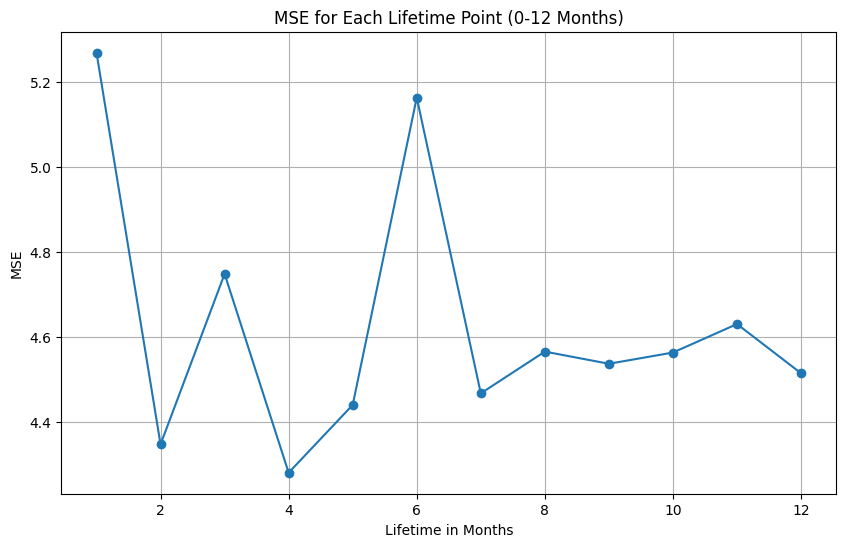

In [ ]:
import matplotlib.pyplot as plt

# Collect the MSE data for plotting
mse_data = mse_df.collect()
months = [row['month'] for row in mse_data]
mse_values = [row['mse'] for row in mse_data]

# Plot the MSE
plt.figure(figsize=(10, 6))
plt.plot(months, mse_values, marker='o')
plt.xlabel('Lifetime in Months')
plt.ylabel('MSE')
plt.title('MSE for Each Lifetime Point (0-12 Months)')
plt.grid(True)
plt.show()

## For each user’s lifetime point, regress recency, frequency AND her spending behavior profile on Y. Plot the MSE for each lifetime point like above. Did you get any improvement?

In [ ]:
#turn the profile wide
spending_profile_wide = spending_profile.groupBy("user1").pivot("Category").agg(first("spending_profile_percent"))
spending_profile_wide = spending_profile_wide.na.fill('Other')
#spending_profile_wide.show(5)

In [ ]:
spending_profile_wide.show(5)

+-----+--------+-----+-----+------+---------------+------+------+--------------+------+-------+
|user1|Activity| Cash|Event|  Food|Illegal/Sarcasm| Other|People|Transportation|Travel|Utility|
+-----+--------+-----+-----+------+---------------+------+------+--------------+------+-------+
|    3|   Other|Other|Other| 1.28%|          Other|97.44%| 1.28%|         Other| Other|  Other|
|    4|  22.22%|Other|Other|11.11%|         11.11%|44.44%| Other|         Other|11.11%|  Other|
|   10|   Other|Other|Other|10.34%|          Other|86.21%| Other|         3.45%| Other|  Other|
|   12|   1.61%|Other|Other| 1.61%|          Other|95.16%| Other|         Other| Other|  1.61%|
|   13|   1.33%|Other|0.33%| 3.33%|          0.33%|92.00%| 1.33%|         0.67%| Other|  0.67%|
+-----+--------+-----+-----+------+---------------+------+------+--------------+------+-------+
only showing top 5 rows



In [ ]:
#correct the error made
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
columns_to_replace = [col_name for col_name in spending_profile_wide.columns if col_name != 'user1']
for col_name in columns_to_replace:
    spending_profile_wide = spending_profile_wide.withColumn(col_name,
                            regexp_replace(col(col_name), 'Other', '0'))

for col_name in spending_profile_wide.columns:
    if col_name != 'user1':
        spending_profile_wide = spending_profile_wide.withColumn(col_name,
                                regexp_replace(col(col_name), '%', '').cast('double') / 100)

spending_profile_wide.show(5)

+-----+--------------------+----+------+-------------------+-------------------+-------------------+--------------------+--------------+-------------------+-------+
|user1|            Activity|Cash| Event|               Food|    Illegal/Sarcasm|              Other|              People|Transportation|             Travel|Utility|
+-----+--------------------+----+------+-------------------+-------------------+-------------------+--------------------+--------------+-------------------+-------+
|    3|                 0.0| 0.0|   0.0|             0.0128|                0.0| 0.9743999999999999|              0.0128|           0.0|                0.0|    0.0|
|    4| 0.22219999999999998| 0.0|   0.0|0.11109999999999999|0.11109999999999999|0.44439999999999996|                 0.0|           0.0|0.11109999999999999|    0.0|
|   10|                 0.0| 0.0|   0.0|0.10339999999999999|                0.0|             0.8621|                 0.0|        0.0345|                0.0|    0.0|
|   12|   

In [ ]:
#join to final_df
final_df = final_df.join(spending_profile_wide, on="user1", how="left")
final_df.show(5)

+-----+----+-----+-------+--------------------+------------------------+-------------------+----+-----+-------------------+-------------------+-------------------+------+--------------+-------------------+-------+
|user1|year|month|recency|           frequency|total_transactions_in_12|           Activity|Cash|Event|               Food|    Illegal/Sarcasm|              Other|People|Transportation|             Travel|Utility|
+-----+----+-----+-------+--------------------+------------------------+-------------------+----+-----+-------------------+-------------------+-------------------+------+--------------+-------------------+-------+
|   12|2012|   10|     27|30.00000000000000...|                       2|             0.0161| 0.0|  0.0|             0.0161|                0.0|             0.9516|   0.0|           0.0|                0.0| 0.0161|
|    3|2016|   10|     21|6.000000000000000...|                       6|                0.0| 0.0|  0.0|             0.0128|                0.0| 

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Cache the data to improve performance
train_data, test_data = final_df.randomSplit([0.8, 0.2], seed=42)
train_data.cache()
test_data.cache()

mse_list = []

# Prepare the feature columns
feature_columns = ["recency", "frequency"] + spending_profile_wide.columns[1:]

# Prepare the assembler once, including recency, frequency, and spending behavior profile features
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features", handleInvalid="skip")

for month in range(1, 13):
    # Filter the data for the specific month
    train_month_data = assembler.transform(train_data.filter(col("month") == month))
    test_month_data = assembler.transform(test_data.filter(col("month") == month))

    # Train the Linear Regression model
    lr = LinearRegression(labelCol="total_transactions_in_12", featuresCol="features")
    lr_model = lr.fit(train_month_data)

    # Make predictions
    predictions = lr_model.transform(test_month_data)

    # Calculate MSE
    evaluator = RegressionEvaluator(labelCol="total_transactions_in_12", predictionCol="prediction", metricName="mse")
    mse = evaluator.evaluate(predictions)

    # Append the result to the list
    mse_list.append((month, mse))

mse_df = spark.createDataFrame(mse_list, ["month", "mse"])
mse_df.show()


+-----+-----------------+
|month|              mse|
+-----+-----------------+
|    1|4.691377076100509|
|    2|4.266096191854253|
|    3|4.127867741397223|
|    4|4.239359665717073|
|    5|4.391371017124708|
|    6| 4.58569250654283|
|    7|4.370997994493748|
|    8|4.522946367555028|
|    9|4.484742379165759|
|   10|4.715078009139362|
|   11|4.687348308943295|
|   12|4.486845643375508|
+-----+-----------------+



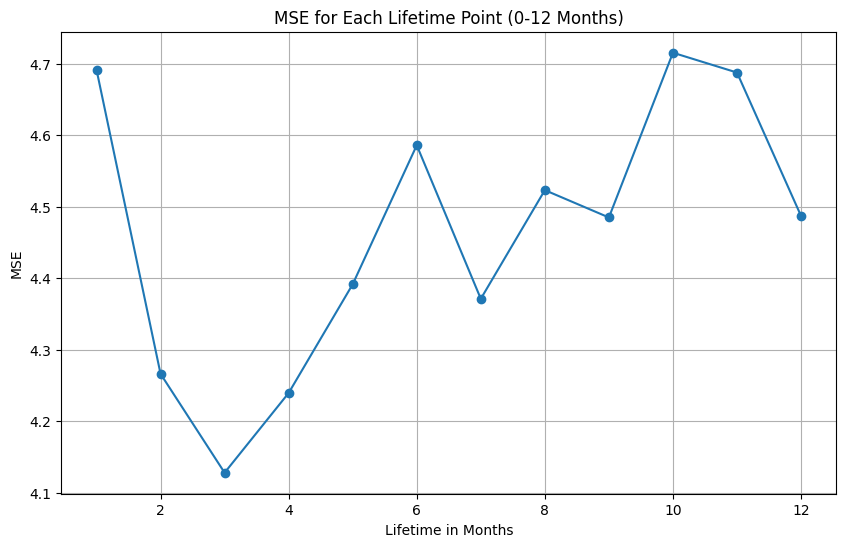

In [ ]:
import matplotlib.pyplot as plt

# Collect the MSE data for plotting
mse_data = mse_df.collect()
months = [row['month'] for row in mse_data]
mse_values = [row['mse'] for row in mse_data]

# Plot the MSE
plt.figure(figsize=(10, 6))
plt.plot(months, mse_values, marker='o')
plt.xlabel('Lifetime in Months')
plt.ylabel('MSE')
plt.title('MSE for Each Lifetime Point (0-12 Months)')
plt.grid(True)
plt.show()

##  For each user’s lifetime point, regress her social network metrics on Y. Plot the MSE for each lifetime point like above. What do you observe? How do social network metrics compare with the RF framework? What are the most informative predictors?


In [ ]:
#integrate social network metrics with final_df
final_df = final_df.join(friends_list_df.select("user1", "friends_count"), on="user1", how="left")
final_df.show(5)


+-----+----+-----+-------+--------------------+------------------------+-------------------+----+-----+-------------------+-------------------+-------------------+------+--------------+-------------------+-------+-------------+
|user1|year|month|recency|           frequency|total_transactions_in_12|           Activity|Cash|Event|               Food|    Illegal/Sarcasm|              Other|People|Transportation|             Travel|Utility|friends_count|
+-----+----+-----+-------+--------------------+------------------------+-------------------+----+-----+-------------------+-------------------+-------------------+------+--------------+-------------------+-------+-------------+
|   12|2012|   10|     27|30.00000000000000...|                       2|             0.0161| 0.0|  0.0|             0.0161|                0.0|             0.9516|   0.0|           0.0|                0.0| 0.0161|            5|
|    3|2016|   10|     21|6.000000000000000...|                       6|                

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# Cache the data to improve performance
train_data, test_data = final_df.randomSplit([0.8, 0.2], seed=42)
train_data.cache()
test_data.cache()

mse_list = []

#social network metrics as features
social_network_columns = ["friends_count"]

# Prepare the assembler once, including recency, frequency, and social network metrics
assembler = VectorAssembler(inputCols=social_network_columns, outputCol="features", handleInvalid="skip")

for month in range(1, 13):
    # Filter the data for the specific month
    train_month_data = assembler.transform(train_data.filter(col("month") == month))
    test_month_data = assembler.transform(test_data.filter(col("month") == month))

    # Train the Linear Regression model
    lr = LinearRegression(labelCol="total_transactions_in_12", featuresCol="features")
    lr_model = lr.fit(train_month_data)

    # Make predictions
    predictions = lr_model.transform(test_month_data)

    # Calculate MSE
    evaluator = RegressionEvaluator(labelCol="total_transactions_in_12", predictionCol="prediction", metricName="mse")
    mse = evaluator.evaluate(predictions)

    # Append the result to the list
    mse_list.append((month, mse))

mse_df = spark.createDataFrame(mse_list, ["month", "mse"])
mse_df.show()

+-----+------------------+
|month|               mse|
+-----+------------------+
|    1| 3.390574015205006|
|    2|  2.63201664909676|
|    3|2.4113257978021587|
|    4| 2.331228951028803|
|    5| 2.420480391028227|
|    6|2.5527479646954676|
|    7| 2.489544213152747|
|    8|2.6967402382936005|
|    9| 2.941918005072581|
|   10| 3.457446514354689|
|   11|  3.66406159524126|
|   12|3.5160632777687044|
+-----+------------------+



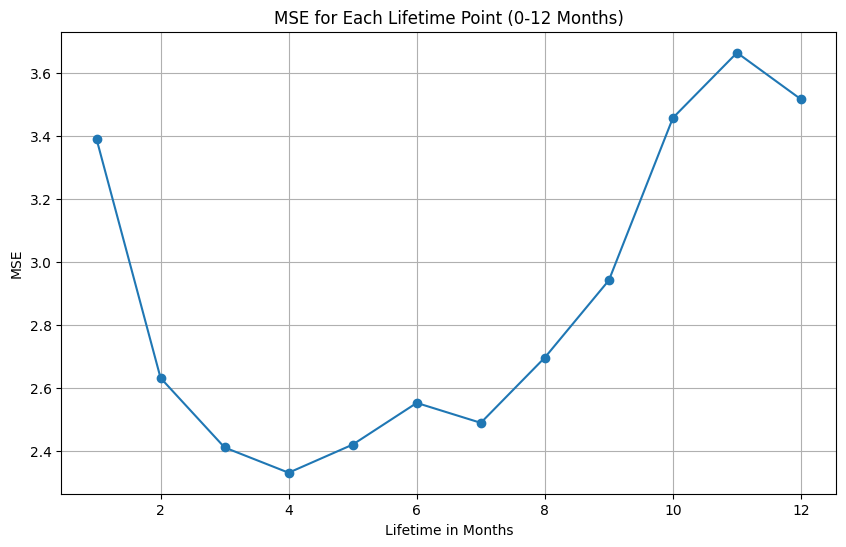

In [ ]:
import matplotlib.pyplot as plt

# Collect the MSE data for plotting
mse_data = mse_df.collect()
months = [row['month'] for row in mse_data]
mse_values = [row['mse'] for row in mse_data]

# Plot the MSE
plt.figure(figsize=(10, 6))
plt.plot(months, mse_values, marker='o')
plt.xlabel('Lifetime in Months')
plt.ylabel('MSE')
plt.title('MSE for Each Lifetime Point (0-12 Months)')
plt.grid(True)
plt.show()

##  For each user’s lifetime point, regress her social network metrics and the spending behavior of her social network on Y. Plot the MSE for each lifetime point like above. Does the spending behavior of her social network add any predictive benefit compared to Q10?


In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

feature_columns = final_df.columns[6:]

# Cache the data to improve performance
train_data, test_data = final_df.randomSplit([0.8, 0.2], seed=42)
train_data.cache()
test_data.cache()

mse_list = []

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features", handleInvalid="skip")

for month in range(1, 13):
    # Filter the data for the specific month
    train_month_data = assembler.transform(train_data.filter(col("month") == month))
    test_month_data = assembler.transform(test_data.filter(col("month") == month))

    # Train the Linear Regression model
    lr = LinearRegression(labelCol="total_transactions_in_12", featuresCol="features")
    lr_model = lr.fit(train_month_data)

    # Make predictions
    predictions = lr_model.transform(test_month_data)

    # Calculate MSE
    evaluator = RegressionEvaluator(labelCol="total_transactions_in_12", predictionCol="prediction", metricName="mse")
    mse = evaluator.evaluate(predictions)

    # Append the result to the list
    mse_list.append((month, mse))

mse_df = spark.createDataFrame(mse_list, ["month", "mse"])
mse_df.show()

+-----+------------------+
|month|               mse|
+-----+------------------+
|    1|3.3842658557101055|
|    2|2.6265167628119337|
|    3| 2.406447050401278|
|    4|2.3267995130257306|
|    5|2.4164000765619633|
|    6|2.5491906012118144|
|    7| 2.486089841265405|
|    8|2.6920392165804756|
|    9|2.9358793237401737|
|   10|3.4517269441431995|
|   11|3.6579625954978736|
|   12| 3.507733366212548|
+-----+------------------+



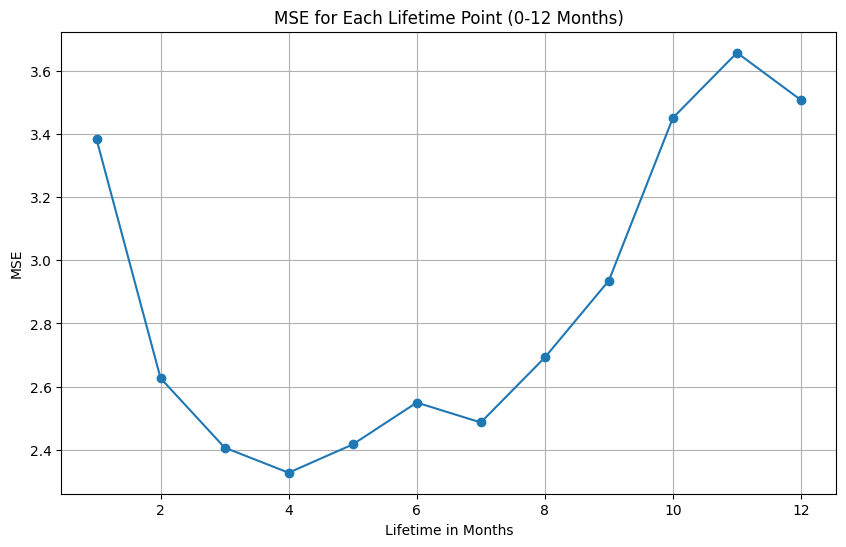

In [ ]:
# Collect the MSE data for plotting
mse_data = mse_df.collect()
months = [row['month'] for row in mse_data]
mse_values = [row['mse'] for row in mse_data]

# Plot the MSE
plt.figure(figsize=(10, 6))
plt.plot(months, mse_values, marker='o')
plt.xlabel('Lifetime in Months')
plt.ylabel('MSE')
plt.title('MSE for Each Lifetime Point (0-12 Months)')
plt.grid(True)

# ***Part4: Graph Neural Network (GNN) Analysis***

VenmoSample.snappy.parquet


In [ ]:

import pandas as pd

# Load the emoji classification dictionary
emoji_df = pd.read_csv('Venmo_Emoji_Classification_Dictionary.csv')

# Display the first few rows of the dataframe
print(emoji_df)



,Event,Travel,Food,Activity,Transportation,People,Utility
0,🇦🇺,🏔,🍇,👾,🚄,😀,⚡
1,🇫🇷,⛰,🍈,🕴,🚅,😃,💡
2,🎂,🌋,🍉,🎪,🚆,😄,🔌
3,🛍,🗻,🍊,🎭,🚇,😁,📺
4,🇨🇦,🏕,🍋,🎨,🚈,😆,🔌


In [ ]:
!pip install fastparquet

In [ ]:

import pyarrow.parquet as pq

# Load the Venmo transaction data using pandas with the appropriate engine
venmo_df = pd.read_parquet('VenmoSample.snappy.parquet', engine='pyarrow')

# Display the first few rows of the dataframe
print(venmo_df.head())


     user1    user2 transaction_type            datetime   description  \
0  1218774  1528945          payment 2015-11-27 10:48:19          Uber   
1  5109483  4782303          payment 2015-06-17 11:37:04        Costco   
2  4322148  3392963          payment 2015-06-19 07:05:31  Sweaty balls   
3   469894  1333620           charge 2016-06-03 23:34:13             🎥   
4  2960727  3442373          payment 2016-05-29 23:23:42             ⚡   

  is_business                  story_id  
0       False  5657c473cd03c9af22cff874  
1       False  5580f9702b64f70ab0114e94  
2       False  55835ccb1a624b14ac62cef4  
3       False  5751b185cd03c9af224c0d17  
4       False  574b178ecd03c9af22cf67f4  


#

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.3 MB/s eta 0:00:00


In [ ]:
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 7.5 MB/s eta 0:00:00


In [ ]:
import networkx as nx
from torch_geometric.utils import from_networkx
import pandas as pd
import emoji

# Load the emoji classification dictionary
emoji_df = pd.read_csv('Venmo_Emoji_Classification_Dictionary.csv')

# Load the Venmo transaction data using pandas with the appropriate engine
venmo_df = pd.read_parquet('VenmoSample.snappy.parquet', engine='pyarrow')

# Create a graph where users are nodes and transactions represent edges
G = nx.from_pandas_edgelist(venmo_df, source='user1', target='user2')

# Create mappings for each category
categories = ['Event', 'Travel', 'Food', 'Activity', 'Transportation', 'People', 'Utility']
emoji_dict = {}

for category in categories:
    for emoji_item in emoji_df[category]:
        if pd.notna(emoji_item):
            emoji_dict[emoji_item] = category

# Function to extract emojis from description
def extract_emojis(text):
    return ''.join(c for c in text if emoji.is_emoji(c))

# Add emoji category features to the nodes
for node in G.nodes():
    G.nodes[node]['emoji_feature'] = []

for index, row in venmo_df.iterrows():
    user1 = row['user1']
    user2 = row['user2']
    emojis = extract_emojis(row['description'])
    categories_present = [emoji_dict.get(e, 'unknown') for e in emojis]

    # If there are emojis in the description, add the categories as node features
    if categories_present:
        if user1 in G.nodes:
            G.nodes[user1]['emoji_feature'].extend(categories_present)
        if user2 in G.nodes:
            G.nodes[user2]['emoji_feature'].extend(categories_present)

# Convert to a PyTorch Geometric data object
data = from_networkx(G)

# Display the first few rows of the data
print(data)


Data(edge_index=[2, 9995562], emoji_feature=[3018657], num_nodes=3018657)


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

# Check if data is None
if data is None:
    raise ValueError("Failed to convert NetworkX graph to PyTorch Geometric data object.")

# Check if the necessary attributes are present
if not hasattr(data, 'x') or not hasattr(data, 'edge_index') or not hasattr(data, 'y'):
    raise ValueError("Data object is missing necessary attributes.")

print(data)


Data(edge_index=[2, 9995562], emoji_feature=[3018657], num_nodes=3018657)


In [ ]:
class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

num_classes = data.y.unique().shape[0]
model = GNN(in_channels=data.num_node_features, hidden_channels=16, out_channels=num_classes)


AttributeError: 'NoneType' object has no attribute 'unique'

In [ ]:
import networkx as nx
from torch_geometric.utils import from_networkx
import pandas as pd
import emoji

# Load the emoji classification dictionary
emoji_df = pd.read_csv('Venmo_Emoji_Classification_Dictionary.csv')

# Load the Venmo transaction data using pandas with the appropriate engine
venmo_df = pd.read_parquet('VenmoSample.snappy.parquet', engine='pyarrow')

# Create a graph where users are nodes and transactions represent edges
G = nx.from_pandas_edgelist(venmo_df, source='user1', target='user2')

# Create mappings for each category
categories = ['Event', 'Travel', 'Food', 'Activity', 'Transportation', 'People', 'Utility']
emoji_dict = {}

for category in categories:
    for emoji_item in emoji_df[category]:
        if pd.notna(emoji_item):
            emoji_dict[emoji_item] = category

# Function to extract emojis from description
def extract_emojis(text):
    return ''.join(c for c in text if emoji.is_emoji(c))

# Add emoji category features to the nodes
for node in G.nodes():
    G.nodes[node]['emoji_feature'] = []

for index, row in venmo_df.iterrows():
    user1 = row['user1']
    user2 = row['user2']
    emojis = extract_emojis(row['description'])
    categories_present = [emoji_dict.get(e, 'unknown') for e in emojis]

    # If there are emojis in the description, add the categories as node features
    if categories_present:
        if user1 in G.nodes:
            G.nodes[user1]['emoji_feature'].extend(categories_present)
        if user2 in G.nodes:
            G.nodes[user2]['emoji_feature'].extend(categories_present)

# Convert to a PyTorch Geometric data object
data = from_networkx(G)


# Here we just randomly assign labels for demonstration purposes
import torch
num_nodes = data.num_nodes
data.y = torch.randint(0, 2, (num_nodes,))


data.train_mask = torch.zeros(num_nodes, dtype=torch.bool).bernoulli(0.8)
data.test_mask = ~data.train_mask

print(data)

import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

num_classes = data.y.unique().shape[0]

model = GNN(in_channels=data.num_node_features, hidden_channels=16, out_channels=num_classes)

import torch.optim as optim

def train(model, data, epochs=100):
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

train(model, data)

def evaluate(model, data):
    model.eval()
    _, pred = model(data).max(dim=1)
    correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
    acc = correct / data.test_mask.sum().item()
    return acc

accuracy = evaluate(model, data)
print(f'Accuracy: {accuracy:.4f}')


Data(edge_index=[2, 9995562], emoji_feature=[3018657], num_nodes=3018657, y=[3018657], train_mask=[3018657], test_mask=[3018657])


AttributeError: 'NoneType' object has no attribute 'size'